In [12]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)

from agents import Agent
from bo_py import *
from mouselab import MouselabEnv
from distributions import Normal, Categorical
from policies import FixedPlanPolicy, LiederPolicy
from joblib import Parallel, delayed

import warnings
warnings.filterwarnings("ignore", 
                        message="The objective has been evaluated at this point before.")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import ipyparallel as ipp 
rc = ipp.Client(profile='default', cluster_id='')
ipp.register_joblib_backend()

In [7]:
from bandits import MetaBanditEnv
from evaluation import *

In [4]:
n_arm = 5
max_obs = 25
cost=.01
env = MetaBanditEnv(n_arm, max_obs, cost)
optimal_policy(env)

optimal -> 0.6894554583417463 in 156.08071832777932 sec


In [8]:
#Rerun with unnormalized BO and regression to get separate df, combine them outside

def run_params(n_arm, max_obs=30, cost=.01):
    print(str(n_arm)+' arms. cost: '+ str(cost))
    env = MetaBanditEnv(n_arm, max_obs, cost)
#     train_envs = [env] * 500
    write_bo_policy(n_arm, max_obs, cost,n_calls = 10)
    policies = {
#         'BO-1': bo_policy(train_envs, max_cost=max_obs, n_calls=30),
        'BO10': read_bo_policy(n_arm, max_obs, cost),
#         'meta-greedy': LiederPolicy([1, 1, 0, 0, 1]),
#         'blinkered': blinkered_policy(env),
#         'optimal': optimal_policy(env),
#         'full-observation': LiederPolicy([-100, 0.5, 0.5, 0, 1]),
    }
    
    test_envs = [env] * 2000
    def test():
        for name, policy in policies.items():
            df = evaluate(policy, envs=test_envs)
            df['agent'] = name
            df['n_arm'] = n_arm
            df['max_obs'] = max_obs
            df['cost'] = cost
            yield df
    return pd.concat(test())
data = []
for n_arm in range(2,6):
    print('----'+str(n_arm)+'----')
#     for cost in np.logspace(-4, -1, 4):
#         data.append(run_params(n_arm, 15, cost = cost))
    data = Parallel(n_jobs=7)(delayed(run_params)(n_arm,25, cost=cost) 
                           for cost in np.logspace(-4, -1, 7))
    store = pd.HDFStore('9_10_10BO_25OBS(bo_only).h5')
    store['data'+str(n_arm)] = pd.concat(data)
    store.close()
# df = pd.concat(data)
# df = run_params(4, 20, cost=.01)

----2----
2 arms. cost: 0.0001
2 arms. cost: 0.000316227766017
2 arms. cost: 0.001
2 arms. cost: 0.00316227766017
2 arms. cost: 0.0316227766017
2 arms. cost: 0.01
2 arms. cost: 0.1
BO: [ 14.172   0.384   0.324   0.293   1.   ] -> 0.5 in 1 sec
BO: [ 1.485  0.336  0.314  0.351  1.   ] -> 0.55 in 1 sec
BO: [ 3.839  0.37   0.083  0.547  1.   ] -> 0.585 in 2 sec
BO: [ 1.485  0.336  0.314  0.351  1.   ] -> 0.622 in 3 sec
BO: [ 11.168   0.327   0.222   0.451   1.   ] -> 0.652 in 5 sec
BO: [ 3.839  0.37   0.083  0.547  1.   ] -> 0.663 in 7 sec
BO: [ 14.172   0.384   0.324   0.293   1.   ] -> 0.661 in 8 sec
----3----
3 arms. cost: 0.000316227766017
3 arms. cost: 0.0001
3 arms. cost: 0.001
3 arms. cost: 0.1
3 arms. cost: 0.01
3 arms. cost: 0.0316227766017
3 arms. cost: 0.00316227766017
BO: [ 14.172   0.384   0.324   0.293   1.   ] -> 0.5 in 1 sec
BO: [ 3.839  0.37   0.083  0.547  1.   ] -> 0.58 in 2 sec
BO: [ 3.839  0.37   0.083  0.547  1.   ] -> 0.643 in 4 sec
BO: [ 3.839  0.37   0.083  0.547  

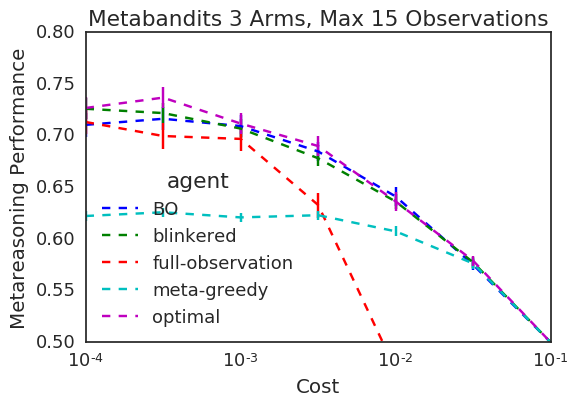

In [11]:
store = pd.HDFStore('9_10_100BO_25OBS.h5')
df = store['data3']
error = df.groupby('cost agent'.split()).util.std().unstack()*1.96/np.sqrt(1000)
# print(error)
# error = df.util.std()*1.96/np.sqrt(1000)
(df
 .query('n_arm == 3')

 .groupby('cost agent'.split())
 .util.mean().unstack()
 .plot(logx=True, ls='--',yerr=error, by='n_arm'))
plt.ylim(0.5,0.8)
# plt.xlim(10**-4.05,10**-0.95)
plt.ylabel('Metareasoning Performance')
plt.xlabel('Cost')
plt.title('Metabandits 3 Arms, Max 15 Observations')

In [14]:
store = pd.HDFStore('9_9_350_30.h5')

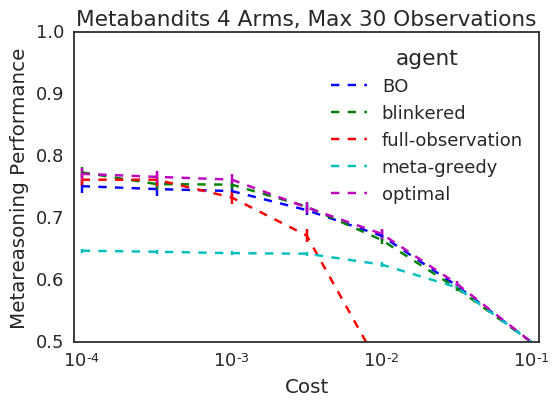

In [25]:
df = store['data4']
error = df.groupby('cost agent'.split()).util.std().unstack()*1.96/np.sqrt(1000)
# print(error)
# error = df.util.std()*1.96/np.sqrt(1000)
(df
 .query('n_arm == 4')

 .groupby('cost agent'.split())
 .util.mean().unstack()
 .plot(logx=True, ls='--',yerr=error, by='n_arm'))
plt.ylim(0.5,1)
plt.xlim(10**-4.05,10**-0.95)
plt.ylabel('Metareasoning Performance')
plt.xlabel('Cost')
plt.title('Metabandits 4 Arms, Max 30 Observations')

12.425000000000001

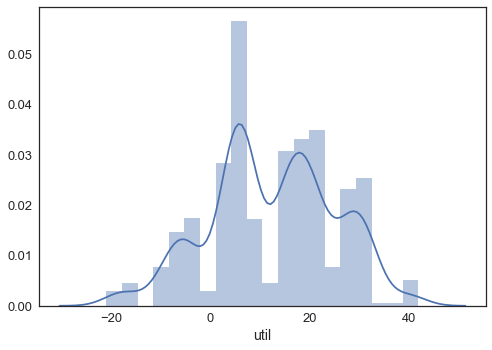

In [62]:
sns.distplot(df.query('agent == "BO"').util)
df.query('agent == "BO"').util.mean()

In [16]:
env = MetaBanditEnv(5, 20, 0.01)
policy = LiederPolicy([1,1,1,1,1])
agent = Agent()
agent.register(env)
agent.register(policy)

def test():
    tr = agent.run_episode()
    print(len(tr['actions']))

%prun test()

21
 